In [4]:
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [5]:
## Get image name list
image_data_path = "../data/original_img/"
_image_files = os.listdir(image_data_path)
image_files = list(map(lambda image_file_name : image_data_path + image_file_name , _image_files))


In [6]:
class LineSegment: 
    def __init__(self, point0, point1, image):
        def show_lines(image):
            gray = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            test_image = cv2.line(gray, (self.point0[0], self.point0[1]), (self.point1[0], self.point1[1]), (0, 255, 0), 3)
            width = 10
            height = 20
            plt.figure(figsize=(width, height))
            plt.imshow(test_image)
            plt.show()
        
        # point[0] -> x point[1] -> y
        self.point0 = point0
        self.point1 = point1
        
        self.length = math.sqrt((point0[0]-point1[0])**2.0 + (point0[1]-point1[1])**2.0)
        
        #show_lines(image)
        
        # line are described by 'y = ax + b'
        if(abs(point1[0] - point0[0]) > 0.0001):
            self.a = (self.point1[1] - self.point0[1] )/(self.point1[0] - self.point0[0])
            self.b = -(self.point1[1] - self.point0[1] )/(self.point1[0] - self.point0[0])*point0[0] + point0[1]

            # angle
            rad = math.atan(self.a)
            degree = math.degrees(rad)
            if(int(degree) < 0):
                degree = 180.0 + degree
            self.angle = degree

            if(False):
                show_lines(image)
                print("angle[degree] : ", self.angle)
                print("point0[x,y] : ", self.point0[0], " , " , self.point0[1])
                print("point1[x,y] : ", self.point1[0], " , " , self.point1[1])
        else:
            self.a = 1000.0
            self.b = 0.0

            # angle
            rad = math.atan(self.a)
            self.angle = math.degrees(rad)

            if(False):
                show_lines(image)
                print("angle[degree] : ", self.angle)
                print("point0[x,y] : ", self.point0[0], " , " , self.point0[1])
                print("point1[x,y] : ", self.point1[0], " , " , self.point1[1])
    
    def __lt__(self, other):
        return self.length > other.length

[[250.29808, 1190.98], [1769.1816, 1183.4392], [237.41621, 205.16794], [1764.0381, 206.27052]]


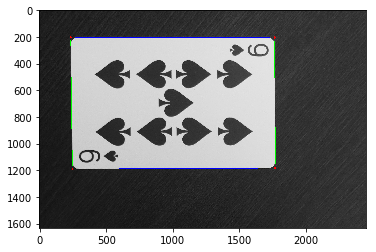

[[250.29808, 1190.98], [1769.1816, 1183.4392], [237.41621, 205.16794], [1764.0381, 206.27052]]
[[640, 300], [0, 300], [640, 0], [0, 0]]


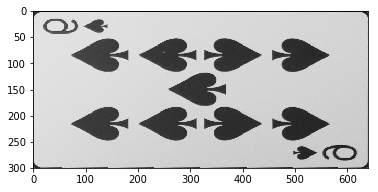

In [20]:
def get_card_template( image_file_name ):
    
    def calc_intersection_points(line_segment0, line_segment_list):
        intersection_points = []
        for line_segment1 in line_segment_list:
            d = []
            d.append(math.sqrt((line_segment0.point0[0]-line_segment1.point0[0])**2 + (line_segment0.point0[1]-line_segment1.point0[1])**2))
            d.append(math.sqrt((line_segment0.point1[0]-line_segment1.point0[0])**2 + (line_segment0.point1[1]-line_segment1.point0[1])**2))
            d.append(math.sqrt((line_segment0.point0[0]-line_segment1.point1[0])**2 + (line_segment0.point0[1]-line_segment1.point1[1])**2))
            d.append(math.sqrt((line_segment0.point1[0]-line_segment1.point1[0])**2 + (line_segment0.point1[1]-line_segment1.point1[1])**2))
            distance = min(d)
            if(distance < 100):
                intersection = [(line_segment1.b - line_segment0.b)/(line_segment0.a - line_segment1.a),
                                         (line_segment0.a*line_segment1.b - line_segment1.a*line_segment0.b)/(line_segment0.a - line_segment1.a)]

                intersection_points.append(intersection)

        return intersection_points
            
    _src_image = cv2.imread(image_file_name, 0)
    src_image = _src_image[:int(_src_image.shape[0]/2)]

    lsd = cv2.createLineSegmentDetector(0)
    lines = lsd.detect(src_image)[0]
    
    line_segments = []
    for line_index in range(len(lines)):
        line_segments.append( LineSegment( [lines[line_index][0][0], lines[line_index][0][1]],
                                                                           [lines[line_index][0][2], lines[line_index][0][3]],
                                                                           src_image ) )
    
    line_segments.sort()
    
    card_edge_candidates = line_segments[:50]
    
    edge_vertical = []
    edge_horizontal = []
    
    for ls in card_edge_candidates:
        if((ls.angle > 60 and ls.angle < 120) and len(edge_vertical) < 2):
            edge_vertical.append(ls)
        
        if((ls.angle < 30 or ls.angle > 150) and len(edge_horizontal) < 2):
            edge_horizontal.append(ls)
            
    lineThickness = 4
    src_image = cv2.cvtColor(src_image, cv2.COLOR_GRAY2BGR)

    cv2.line(src_image, ( edge_vertical[0].point0[0],edge_vertical[0].point0[1]),
                                        (  edge_vertical[0].point1[0],edge_vertical[0].point1[1]),
                                         (0,255,0), lineThickness)
    cv2.line(src_image, ( edge_vertical[1].point0[0],edge_vertical[1].point0[1]),
                                        (  edge_vertical[1].point1[0],edge_vertical[1].point1[1]),
                                         (0,255,0), lineThickness)
    
    cv2.line(src_image, ( edge_horizontal[0].point0[0],edge_horizontal[0].point0[1]),
                                        (  edge_horizontal[0].point1[0],edge_horizontal[0].point1[1]),
                                         (0,0,255), lineThickness)
    cv2.line(src_image, ( edge_horizontal[1].point0[0],edge_horizontal[1].point0[1]),
                                        (  edge_horizontal[1].point1[0],edge_horizontal[1].point1[1]),
                                         (0,0,255), lineThickness)
    
    ips0 = calc_intersection_points(edge_horizontal[0], edge_vertical)
    ips1 = calc_intersection_points(edge_horizontal[1], edge_vertical)    

    intersection_points  = ips0 + ips1
    print(intersection_points)
    
    sorted_intersection_poitns = []
    
    for pt in intersection_points:
        cv2.circle(src_image, (pt[0],pt[1]) , 5, (255,0,0), 5)
    
    #cv2.imwrite("test.png",src_image)
    
    plt.imshow(src_image)
    plt.show()
    
    template_corners = [ [640 , 300] , [0 , 300] , [640 , 0] , [0 , 0] ]
   
    print(intersection_points)
    print(template_corners)
    
    H = cv2.getPerspectiveTransform(np.float32(intersection_points), np.float32(template_corners))
    
    dst_image = cv2.warpPerspective(src_image, H, (640,300))
    
    plt.imshow(dst_image)
    plt.show()
    
    return len(card_edge_candidates)



#line_segment_num = get_card_template(sorted(image_files)[-1])
line_segment_num = get_card_template((image_files[-1])

#for i in image_files:
#    line_segment_num = get_card_template(i)
